# Unsupervised Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
from math import acos, sin, cos, pi
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#Need to be installed
import folium

## Data Preperation

In [2]:
def load_bike_dataset():
    df_bikes = pd.read_csv("../sf_2018.csv")
    
    # Drop all NaN values
    df_bikes=df_bikes.dropna().reset_index(drop=True)
    
    df_bikes['start_time'] = pd.to_datetime(df_bikes['start_time'], format='%Y-%m-%d %H:%M:%S')
    df_bikes['start_hour'] = df_bikes['start_time'].dt.hour
    df_bikes['start_dayofweek'] = df_bikes['start_time'].dt.dayofweek

    df_bikes['end_time'] = pd.to_datetime(df_bikes['end_time'], format='%Y-%m-%d %H:%M:%S')
    df_bikes['end_hour'] = df_bikes['end_time'].dt.hour
    df_bikes['end_dayofweek'] = df_bikes['end_time'].dt.dayofweek

    df_bikes['trip_duration'] = df_bikes['end_time'] - df_bikes['start_time']
    df_bikes["trip_duration"] = df_bikes["trip_duration"].apply(lambda x: x.total_seconds() / 60)

    # Drop start/end_time because obsolete
    df_bikes.drop(['start_time', 'end_time'], axis=1, inplace=True)
    
    # Drop start/end_station_id because correspond to name and arent unique per station
    # Drop bike_id because not interesting
    df_bikes.drop(['start_station_id', 'end_station_id', 'bike_id'], axis=1, inplace=True)
    return df_bikes

In [3]:
def load_geodata():
    
    df_stations = pd.read_csv("../data/geo_data.csv")

    #remove unnecessary endings
    df_stations["station"] = df_stations["station"].apply(lambda x: x.removesuffix(', San Francisco'))

    #drop not used columns
    df_stations.drop(['result'], axis=1, inplace=True)
    return df_stations

In [4]:
def calculate_distance(row):
    lat1 = row['start_lat']
    lng1 = row['start_lng']
    lat2 = row['end_lat']
    lng2 = row['end_lng']
    temp_result = sin(lat1/(180/pi))*sin(lat2/(180/pi))
    temp_result += cos(lat1/(180/pi))*cos(lat2/(180/pi))*cos(lng2/(180/pi)-lng1/(180/pi))
    
    # Can get a value of 1.0000000000000002 for same lat1/2 lng1/2. Needs to be rounded.
    temp_result = round(temp_result, 15)
    return acos(temp_result)*6371

def run_calculate_distance(df_bikes, df_stations):
    df_bikes = df_bikes.merge(df_stations.rename(columns={'lat': 'start_lat', 'lng': 'start_lng'}), how='inner', left_on='start_station_name', right_on='station')
    df_bikes = df_bikes.merge(df_stations.rename(columns={'lat': 'end_lat', 'lng': 'end_lng'}), how='inner', left_on='end_station_name', right_on='station')
    df_bikes['distance'] = df_bikes.apply(calculate_distance, axis=1)
    df_bikes.drop(['station_x', 'station_y'], axis=1, inplace=True)
    return df_bikes

In [5]:
df_bikes = load_bike_dataset()
df_stations = load_geodata()
df_bikes = run_calculate_distance(df_bikes, df_stations)

## Geo Data Clusters

In [6]:
def run_elbow_with_kmean(X_data, k_max):
    clusters = []
    losses = []
    for k in range(0, k_max, 1):
        model = KMeans(n_clusters=k+1)
        model.fit(X_data)
        clusters.append(k+1)
        losses.append(model.inertia_)
        #print("[{k}/{k_max}] Cluster finished!".format(k=int((k+1)), k_max=int(k_max)))
    
    # plot 1
    plt.subplot(1, 2, 1)
    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")

    # plot 2
    plt.subplot(1, 2, 2)
    plt.plot(clusters, losses)
    plt.ylabel("Loss")
    plt.xlabel("Number of clusters")
    plt.xlim([0,8])

    plt.rcParams["figure.figsize"] = (20,6)
    plt.show()

In [7]:
def run_kmeans_cluster(X_data, n_clusters_):
    kmeans = KMeans(n_clusters = n_clusters_)
    kmeans.fit(X_data)
    labels = kmeans.predict(X_data)
    return labels, kmeans.cluster_centers_ 

In [8]:
def plot_geo_clusters(X_data, labels, centers):
    plt.rcParams['figure.figsize'] = [16,13]

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    #BBox = (14.599512,37.880225,-122.501534,-120.984219)
    fig, ax = plt.subplots()
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = X_data[class_member_mask]
        ax.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=5)
        ax.plot(centers[k, 0], centers[k, 1], '^',markerfacecolor=tuple(col), markersize=18)
        ax.text(centers[k, 0], centers[k, 1], k,fontsize=12) 
    #ax.set_xlim(BBox[0],BBox[1])
    #ax.set_ylim(BBox[2],BBox[3])
    # ax.imshow(map_tor, zorder=0, extent = BBox, aspect= 'equal')
    plt.show()

def plot_geo_clusters_on_map(df, labels, centers):
    lons = df['lng']
    lats = df['lat']
    n_clusters = len(centers)

    colors = sns.color_palette("bright", n_clusters).as_hex()
    mapObj = folium.Map(location=[37.58239254351921, -122.16408307676589], zoom_start = 10)
    # create points with one color per cluster
    for i in range(0,len(lats)):
            folium.CircleMarker([lats.iloc[i], lons.iloc[i]], radius=2, color=colors[labels[i]]).add_to(mapObj)
    
    # create cluster centers
    for i in range(0,n_clusters):
            folium.CircleMarker([centers[i, 0], centers[i, 1]], radius=3, color='black').add_to(mapObj)
    return mapObj

In [9]:
X_Geo_Data = df_stations[['lat', 'lng']].values
labels, centers = run_kmeans_cluster(X_Geo_Data, 10)
plot_geo_clusters_on_map(df_stations, labels, centers)

## Bike Data Clusters

In [10]:
def preprocess_data_behaviour_cluster(df_input):
    df = df_input.copy()
    #df.drop(['start_station_name', 'end_station_name', 'start_lat', 'start_lng', 'end_lat', 'end_lng'], axis=1, inplace=True)
    df.drop(['start_station_name', 'end_station_name'], axis=1, inplace=True)
    
    ordinalencoder = OrdinalEncoder()
    df['user_type'] = ordinalencoder.fit_transform(df[['user_type']])
    print(ordinalencoder.categories_)

    scaler = StandardScaler()
    scaler.fit(df)
    X_scaled = scaler.transform(df)
    #X_scaled_df = pd.DataFrame(X_scaled, columns=df.columns, index=df.index)
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    print(pca.components_)
    print(list(df.columns))
    print(sum(pca.explained_variance_ratio_))
    
    return X_pca, df , ordinalencoder, scaler, pca

In [11]:
def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    pd.plotting.parallel_coordinates(df, 'cluster', color=sns.color_palette("bright", num_clusters))

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)    

In [12]:
X_pca, df, ordEnc, scaler, pca = preprocess_data_behaviour_cluster(df_bikes)

[array(['Customer', 'Subscriber'], dtype=object)]
[[ 0.03157196  0.03575854  0.01547647  0.03306819  0.01547907 -0.01235027
  -0.49945757  0.49550152 -0.50097682  0.4973065  -0.05223251]
 [-0.21926869  0.36550612  0.57927422  0.36828882  0.57921593  0.10170505
   0.02269415 -0.01183353  0.0180377  -0.01712967  0.00473188]]
['user_type', 'start_hour', 'start_dayofweek', 'end_hour', 'end_dayofweek', 'trip_duration', 'start_lat', 'start_lng', 'end_lat', 'end_lng', 'distance']
0.5063222167940605


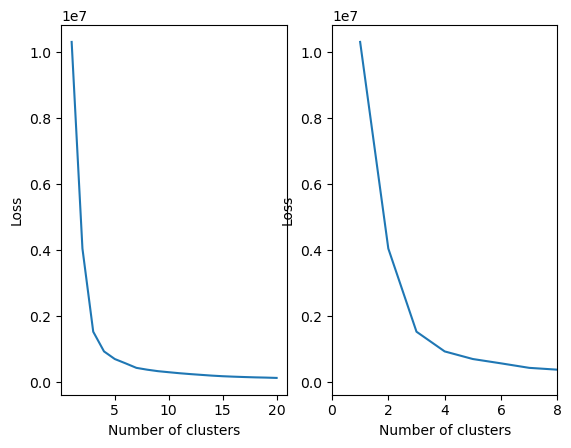

In [13]:
run_elbow_with_kmean(X_pca, 20)

In [14]:
labels, centers = run_kmeans_cluster(X_pca, 3)
df["label"] = labels

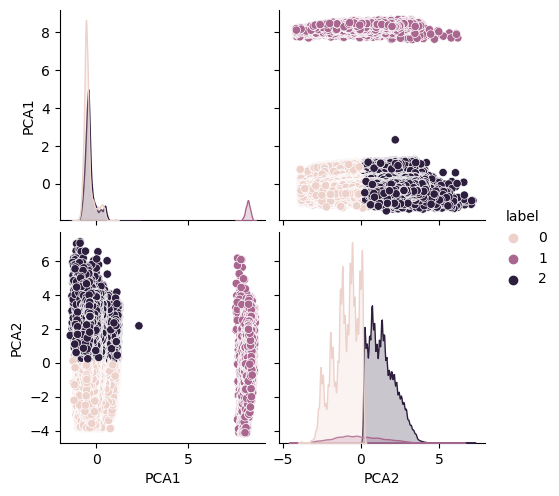

In [15]:
Pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'], index=df.index)
Pca_df["label"] = labels
sns.pairplot(data=Pca_df, hue="label")

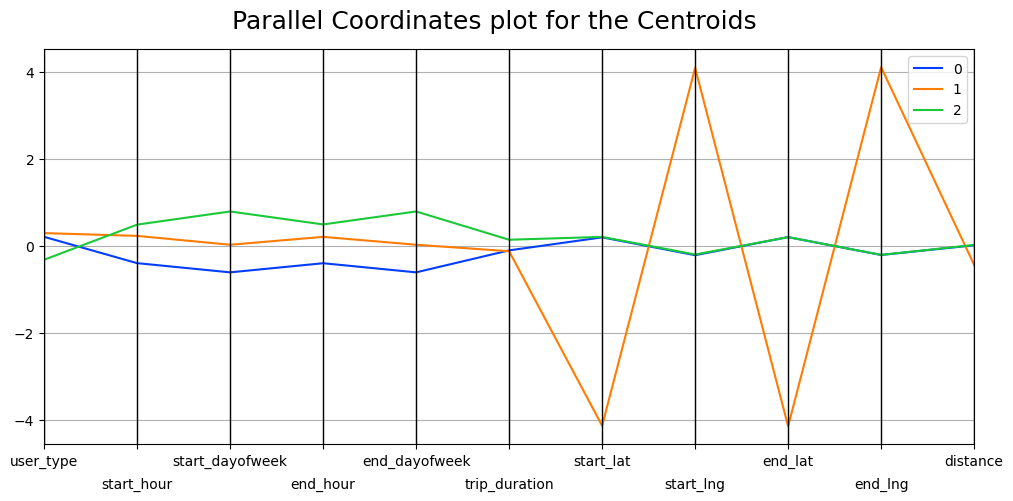

In [16]:
# Create a data frame containing our centroids
centroids = pca.inverse_transform(centers)
centroids = pd.DataFrame(centroids, columns=df.columns[:-1])
centroids['cluster'] = centroids.index

display_parallel_coordinates_centroids(centroids, 4)

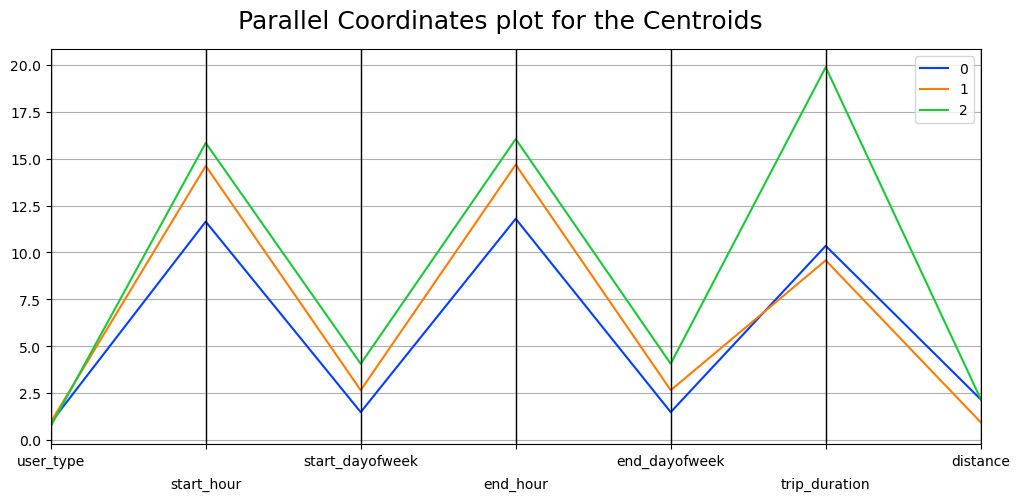

In [17]:
# Create a data frame containing our centroids
centroid = scaler.inverse_transform(pca.inverse_transform(centers))
centroids = pd.DataFrame(centroid[:,:6], columns=df.columns[:6])
centroids['distance'] = centroid[:,10]
centroids['cluster'] = centroids.index

display_parallel_coordinates_centroids(centroids, 4)